In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Read the data from the CSV file
cap_budg = pd.read_csv('../data/capital_budget.csv')
op_budg = pd.read_csv('../data/operating_budget.csv')

# Clean the data
op_budg.replace("#Missing", 0, inplace=True)
op_budg['FY22 Actual Expense'] = pd.to_numeric(op_budg['FY22 Actual Expense'].str.replace(',', ''))
op_budg['FY23 Actual Expense'] = pd.to_numeric(op_budg['FY23 Actual Expense'].str.replace(',', ''))
op_budg['FY24 Appropriation'] = pd.to_numeric(op_budg['FY24 Appropriation'].str.replace(',', ''))
op_budg['FY25 Budget'] = pd.to_numeric(op_budg['FY25 Budget'].str.replace(',', ''))

# Summing expenses by department for each fiscal year
dept_spending = op_budg.groupby('Dept')[['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation', 'FY25 Budget']].sum()
dept_spending = dept_spending.sort_values('FY25 Budget', ascending=False)

In [3]:
# Time Series Analysis and Forecasting

# Prepare time series data for a specific department (can explore other departments)
departments = op_budg['Dept'].unique()
forecast_results = []

for dept in departments:
  dept_data = op_budg[op_budg['Dept'] == dept][['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation', 'FY25 Budget']].sum()
  dept_data.index = pd.to_datetime(['2022', '2023', '2024', '2025'])
  dept_series = dept_data.squeeze()

  if dept_data.empty or (dept_data == 0).all():
    print(f"Skipping {dept} due to insufficient data.")
    continue

  if len(dept_series) < 3:
    print(f"Skipping {dept} due to insufficient data points for ARIMA model.")
    continue

  try:
    # Fit ARIMA model
    model = ARIMA(dept_series, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=5)
    forecast.index = pd.to_datetime(['2026', '2027', '2028', '2029', '2030'], format='%Y')

    # Convert scientific notation to float and add dollar sign + commas
    forecast = forecast.apply(lambda x: f'${x:,.2f}')

    # Store the forecasted values
    forecast_results.append({
      'Dept': dept,
      'Forecast_2026': forecast.iloc[0],
      'Forecast_2027': forecast.iloc[1],
      'Forecast_2028': forecast.iloc[2],
      'Forecast_2029': forecast.iloc[3],
      'Forecast_2030': forecast.iloc[4]
    })
  except Exception as e:
    print(f"Could not fit model for {dept}: {e}")
    continue

# Convert the results into a DataFrame
forecast_df = pd.DataFrame(forecast_results)
forecast_df.set_index('Dept', inplace=True)

# Display the forecasted expenses for Boston Public Schools
print('Example: Forecasted Expenses for Boston Public Schools')
print(forecast_df.loc['Boston Public Schools'], '\n')

# Display forecasted expenses for all departments
print('Forecasted Expenses for All Departments:')
print(forecast_df)


C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

Example: Forecasted Expenses for Boston Public Schools
Forecast_2026    $1,599,975,608.97
Forecast_2027    $1,671,433,609.05
Forecast_2028    $1,741,052,053.54
Forecast_2029    $1,808,878,298.45
Forecast_2030    $1,874,958,480.67
Name: Boston Public Schools, dtype: object 

Forecasted Expenses for All Departments:
                                          Forecast_2026    Forecast_2027  \
Dept                                                                       
Mayor's Office                            $7,452,152.74    $7,303,181.75   
Election Division                         $6,637,506.83    $5,600,171.16   
Listing Board                               $954,483.94    $1,047,967.69   
Intergovernmental Relations               $1,319,528.55    $1,315,273.96   
Law Department                           $11,460,810.01   $11,644,299.19   
...                                                 ...              ...   
OPEB                                     $40,000,000.00   $40,000,000.00   


C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\rehan\AppData\Roaming\Python\Python312\site-packages\statsmo

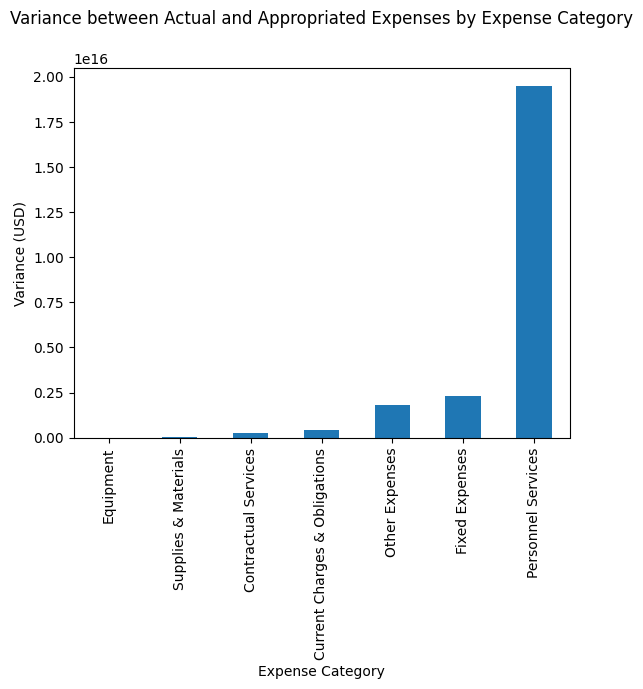

In [4]:
# Variance Analysis

# Calculate variance
op_budg['Variance_FY23'] = (op_budg['FY23 Actual Expense'] - op_budg['FY24 Appropriation']) ** 2
variance_by_dept = op_budg.groupby('Expense Category')['Variance_FY23'].sum().sort_values()

# Plot variance
variance_by_dept.plot(kind='bar', title='Variance between Actual and Appropriated Expenses by Expense Category\n')
plt.ylabel('Variance (USD)')
plt.show()

In [5]:
# Anomaly Detection

# Prepare data
expense_data = op_budg[['FY25 Budget']].fillna(0)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
op_budg['Anomaly'] = iso_forest.fit_predict(expense_data)

# Filter anomalies
anomalies = op_budg[op_budg['Anomaly'] == -1]
print("Anomalies in the Operating Budget:")
print(anomalies[['Dept', 'Program', 'FY25 Budget']])

Anomalies in the Operating Budget:
                                       Dept  \
170        Inspectional Services Department   
247        Youth Employment and Opportunity   
248        Youth Employment and Opportunity   
260                   Boston Public Schools   
264                   Boston Public Schools   
269                   Boston Public Schools   
274                   Boston Public Schools   
279                   Boston Public Schools   
284                   Boston Public Schools   
292                   Boston Public Schools   
296                   Boston Public Schools   
307                   Boston Public Schools   
312                   Boston Public Schools   
322                   Boston Public Schools   
323                   Boston Public Schools   
331                   Boston Public Schools   
332                   Boston Public Schools   
336                   Boston Public Schools   
337                   Boston Public Schools   
339                   Bos

In [6]:
# Predict Departments Over Budget

# Prepare data
op_budg['OverBudget'] = (op_budg['FY22 Actual Expense'] > op_budg['FY24 Appropriation']).astype(int)
features = op_budg[['FY24 Appropriation']].fillna(0)
target = op_budg['OverBudget']

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate model
accuracy = rf_model.score(X_test, y_test)
print('Model Accuracy:', accuracy)

Model Accuracy: 0.671957671957672
